In [158]:
import numpy as np
import pandas as pd
from scipy.stats import rankdata
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"


Rows are: 
South Africa
Switzerland
China
Australia 
Italy 
Brazil 

Columns are: Energy Cost / (USD/kWh)	Water Cost	Ore avaliabilty (Exports) / thousand tonnes	EPS Index	Logistics Performance Index (LPI)	Coruption Index
 

In [62]:
m = np.array([
    [0.191, 1.38, 7200, 0.917, 3.7, 63],
    [0.404, 2.91, 0.0023, 4.500, 4.1, 82],
    [0.078, 0.31, 740, 1.667, 3.7, 42],
    [0.273, 2.80, 3000,	2.917, 3.7, 75],
    [0.457, 1.43, 0.1640, 3.722, 3.7, 56],
    [0.154, 0.76, 620, 0.889, 3.2, 36] 
    ])

m_squared = m ** 2
d_m = np.sqrt(m_squared.sum(axis=0))
normalised_m = m/d_m

weights = np.array([0.15, 0.15, 0.45, 0.1, 0.1, 0.05])
weight_norm = normalised_m * weights

v_plus = np.array([
    min(weight_norm[:, 0]),
    min(weight_norm[:, 1]),
    max(weight_norm[:, 2]),
    max(weight_norm[:, 3]),
    max(weight_norm[:, 4]),
    max(weight_norm[:, 5])
    ])

v_minus = np.array([
    max(weight_norm[:, 0]),
    max(weight_norm[:, 1]),
    min(weight_norm[:, 2]),
    min(weight_norm[:, 3]),
    min(weight_norm[:, 4]),
    min(weight_norm[:, 5])
    ])

positive = (weight_norm - v_plus) ** 2
negative = (weight_norm - v_minus) ** 2

si_plus = np.sqrt(positive.sum(axis=1))
si_minus = np.sqrt(negative.sum(axis=1))
pi = si_minus/ (si_plus + si_minus)

rank = rankdata(-pi)

array([1., 6., 3., 2., 5., 4.])

In [187]:
def sens(m, weights, n=100):

    m_squared = m ** 2
    d_m = np.sqrt(m_squared.sum(axis=0))
    normalised_m = m / d_m

    n_countries = m.shape[0]
    n_weights = weights.shape[0]

    rank_matrix = np.zeros((n_weights, n, n_countries))
    weight_values = np.zeros((n_weights, n))

    for i in range(n_weights):
        test_weights = np.linspace(0, 1, n)
        weight_values[i, :] = test_weights
        for j, w in enumerate(test_weights):
            new_weights = weights.copy()
            remaining_sum = 1 - w
            scaling_factor = remaining_sum / (weights.sum() - weights[i])
            new_weights = new_weights * scaling_factor
            new_weights[i] = w

            weight_norm = normalised_m * new_weights

            v_plus = np.array([
                min(weight_norm[:, 0]),
                max(weight_norm[:, 1]),
                min(weight_norm[:, 2]),
                min(weight_norm[:, 3]),
                max(weight_norm[:, 4]), # need to manually change these for different cases 
                #max(weight_norm[:, 5])
            ])
            v_minus = np.array([
                max(weight_norm[:, 0]),
                min(weight_norm[:, 1]),
                max(weight_norm[:, 2]),
                max(weight_norm[:, 3]),
                min(weight_norm[:, 4]),
                #min(weight_norm[:, 5])
            ])

            positive = (weight_norm - v_plus) ** 2
            negative = (weight_norm - v_minus) ** 2
            si_plus = np.sqrt(positive.sum(axis=1))
            si_minus = np.sqrt(negative.sum(axis=1))

            pi = si_minus / (si_plus + si_minus)

            ranks = rankdata(-pi)
            rank_matrix[i, j, :] = ranks

    return rank_matrix, weight_values

In [177]:
def plot_ranks(rank_matrix, weight_values, titles, country_names, initial_weights, save_path=None):

    n_weights = rank_matrix.shape[0]
    n_countries = rank_matrix.shape[2]
    fig, axes = plt.subplots(n_weights, 1, figsize=(8, 2 * n_weights), sharex=True)
    
    if n_weights == 1:
        axes = [axes]

    # Collect handles and labels for the shared legend
    handles, labels = None, None

    for i in range(n_weights):
        ax = axes[i]

        for k in range(n_countries):
            line, = ax.plot(weight_values[i], rank_matrix[i, :, k], label=country_names[k])
        
        ax.axvline(initial_weights[i], color='black', linestyle='--', linewidth=1, label='Chosen Weight')
        
        ax.set_title(titles[i])
        ax.set_ylabel("Rank")
        ax.invert_yaxis()  
        
        ax.grid(False)
        
        # Save the handles and labels from the first subplot
        if handles is None and labels is None:
            handles, labels = ax.get_legend_handles_labels()

    # Add shared legend above the plots with 2 columns
    fig.legend(handles, labels, loc="upper center", fontsize="small", ncol=2)
    
    plt.xlabel("Weight Value")
    plt.tight_layout(rect=[0, 0, 1, 0.92])  # Adjust layout to make room for the legend
    plt.xlim(0, 1)

    if save_path:
        plt.savefig(save_path, format="pdf", bbox_inches="tight")
        print(f"Plot saved to {save_path}")

    plt.show()


Plot saved to C:\Users\fjm21\OneDrive - Imperial College London\Fourth Year\FYD\TOPSIS&AHP\location_ranks.pdf


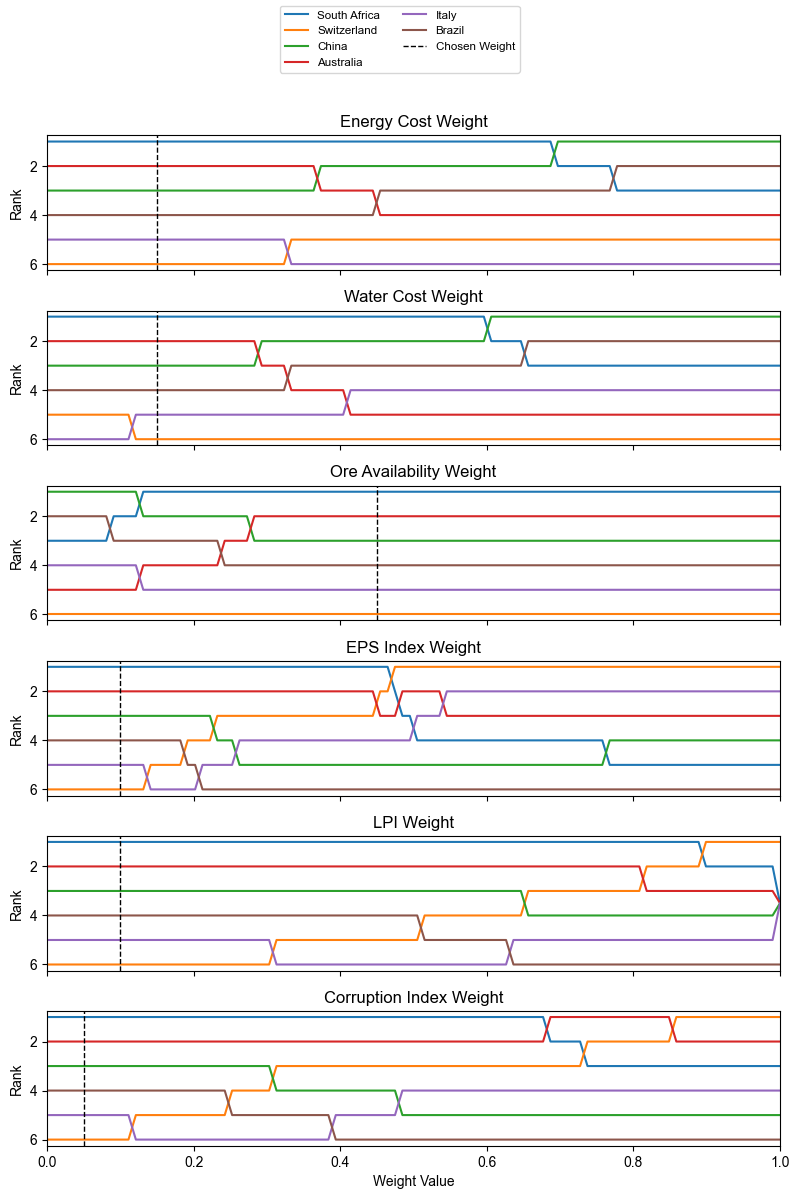

In [178]:
m = np.array([
    [0.191, 1.38, 7200, 0.917, 3.7, 63],
    [0.404, 2.91, 0.0023, 4.500, 4.1, 82],
    [0.078, 0.31, 740, 1.667, 3.7, 42],
    [0.273, 2.80, 3000, 2.917, 3.7, 75],
    [0.457, 1.43, 0.1640, 3.722, 3.7, 56],
    [0.154, 0.76, 620, 0.889, 3.2, 36]
])
weights = np.array([0.15, 0.15, 0.45, 0.1, 0.1, 0.05])

rank_matrix, weight_values = sens(m, weights)

titles = [
    "Energy Cost Weight", "Water Cost Weight", "Ore Availability Weight", 
    "EPS Index Weight", "LPI Weight", "Corruption Index Weight"
]
country_names = ["South Africa", "Switzerland", "China", "Australia", "Italy", "Brazil"]

save_path = r"C:\Users\fjm21\OneDrive - Imperial College London\Fourth Year\FYD\TOPSIS&AHP\location_ranks.pdf"
plot_ranks(rank_matrix, weight_values, titles, country_names, initial_weights=weights, save_path=save_path)


### David MCDM

Plot saved to C:\Users\fjm21\OneDrive - Imperial College London\Fourth Year\FYD\TOPSIS&AHP\alloy_ranks.pdf


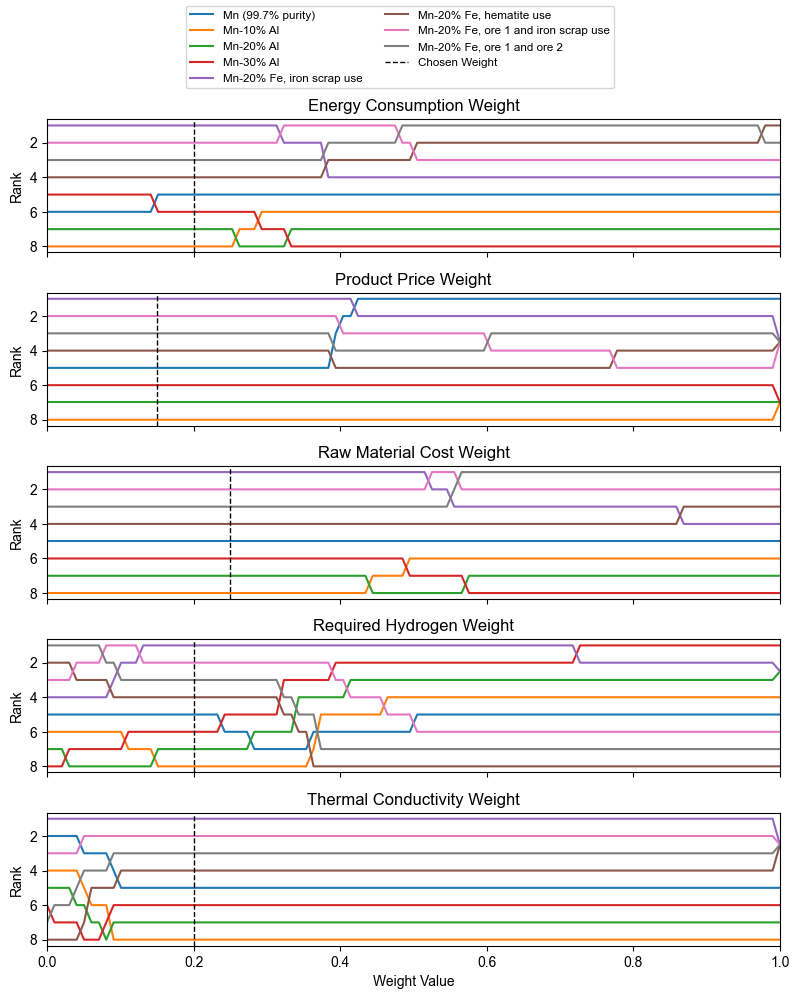

In [188]:
m = np.array([
    [239.7617748, 1380.06,  634.2262035, 22.63450835, 7.8],
    [257.6111061, 1000,  657.6607035, 20.37105751, 3.9],
    [288.1638498, 1000,  685.6697035, 18.10760668, 5.17],
    [318.9916186, 1000,  713.8091035, 15.84415584, 6.43],
    [233.1638498, 1016.46,  620.2697035, 18.10760668, 22.5],
    [181.1638498, 1016.46,  618.979381, 31.2166862, 22.5],
    [205.7954288, 1016.46,  599.217072, 25.01153201, 22.5],
    [181.4211341, 1016.46,  550.9294834, 31.1601626, 22.5]
])

weights = np.array([0.2, 0.15, 0.25, 0.2, 0.2])

rank_matrix, weight_values = sens(m, weights)

titles = [
    "Energy Consumption Weight",
    "Product Price Weight",
    "Raw Material Cost Weight", 
    "Required Hydrogen Weight",
    "Thermal Conductivity Weight"
]
country_names = [
    "Mn (99.7% purity)",
    "Mn-10% Al", 
    "Mn-20% Al", 
    "Mn-30% Al", 
    "Mn-20% Fe, iron scrap use", 
    "Mn-20% Fe, hematite use",
    "Mn-20% Fe, ore 1 and iron scrap use",
    "Mn-20% Fe, ore 1 and ore 2"
]

save_path = r"C:\Users\fjm21\OneDrive - Imperial College London\Fourth Year\FYD\TOPSIS&AHP\alloy_ranks.pdf"
plot_ranks(rank_matrix, weight_values, titles, country_names, initial_weights=weights, save_path=save_path)

### $\mathrm{H_2}$ Production green choice

C:\Users\fjm21\AppData\Local\Temp\ipykernel_24552\1365271755.py:47: RuntimeWarning: invalid value encountered in divide
  pi = si_minus / (si_plus + si_minus)


Plot saved to C:\Users\fjm21\OneDrive - Imperial College London\Fourth Year\FYD\TOPSIS&AHP\hydrogen_ranks.pdf


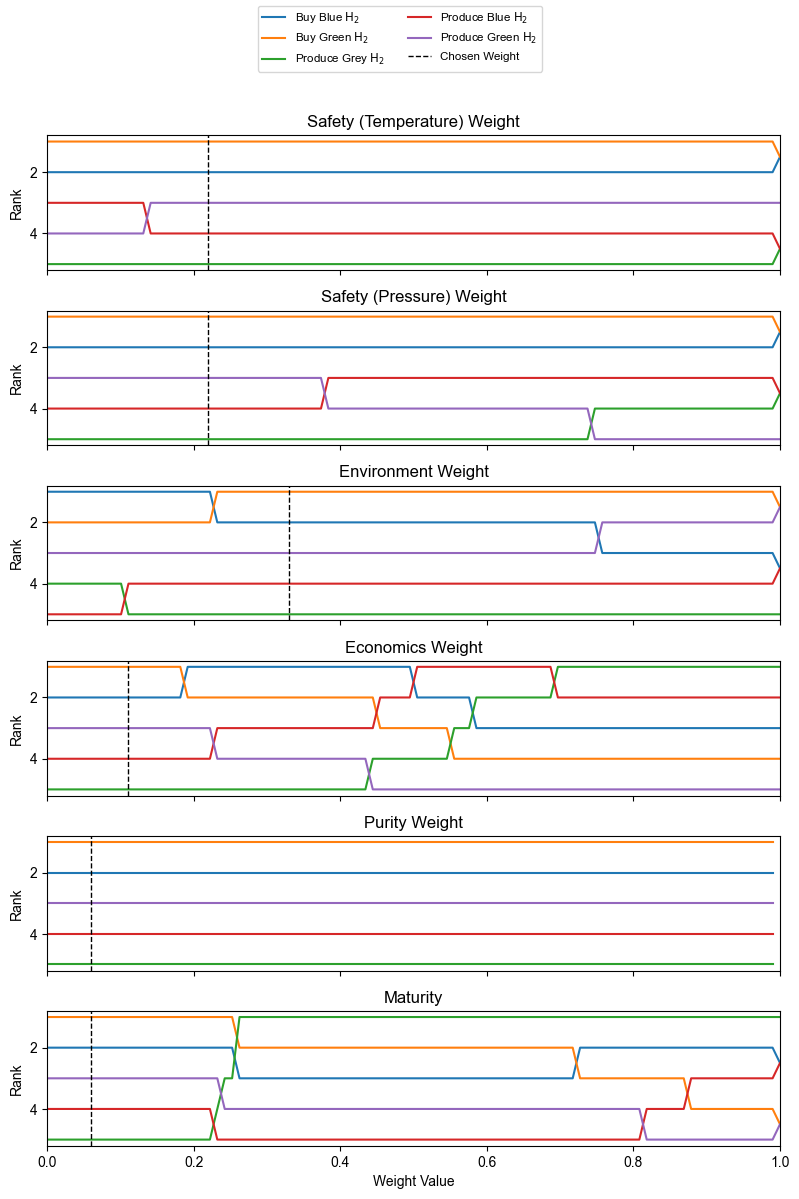

In [186]:
m = np.array([
    [298.0, 1.0, 2500, 4.0, 99.99, 2.0],
    [298.0, 1.0, 1500, 4.4, 99.99, 0.2],
    [1123.0, 25.0, 15000, 2.138, 99.99, 62.0],
    [1123.0, 25.0, 2500, 3.108, 99.99, 2.0],
    [348.0, 30.0, 1500, 6.1, 99.99, 0.2]
])

weights = np.array([0.22, 0.22, 0.33, 0.11, 0.06, 0.06])

rank_matrix, weight_values = sens(m, weights)

titles = [
    "Safety (Temperature) Weight",
    "Safety (Pressure) Weight",
    "Environment Weight", 
    "Economics Weight",
    "Purity Weight",
    "Maturity"
]
country_names = [
    "Buy Blue $\mathrm{H}_2$",
    "Buy Green $\mathrm{H}_2$", 
    "Produce Grey $\mathrm{H}_2$", 
    "Produce Blue $\mathrm{H}_2$", 
    "Produce Green $\mathrm{H}_2$", 
]

save_path = r"C:\Users\fjm21\OneDrive - Imperial College London\Fourth Year\FYD\TOPSIS&AHP\hydrogen_ranks.pdf"
plot_ranks(rank_matrix, weight_values, titles, country_names, initial_weights=weights, save_path=save_path)